### Libraries

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sn

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
sn.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore')

### Data Import

In [ ]:
df = pd.read_csv('train.csv')

### Missing values

<Axes: >

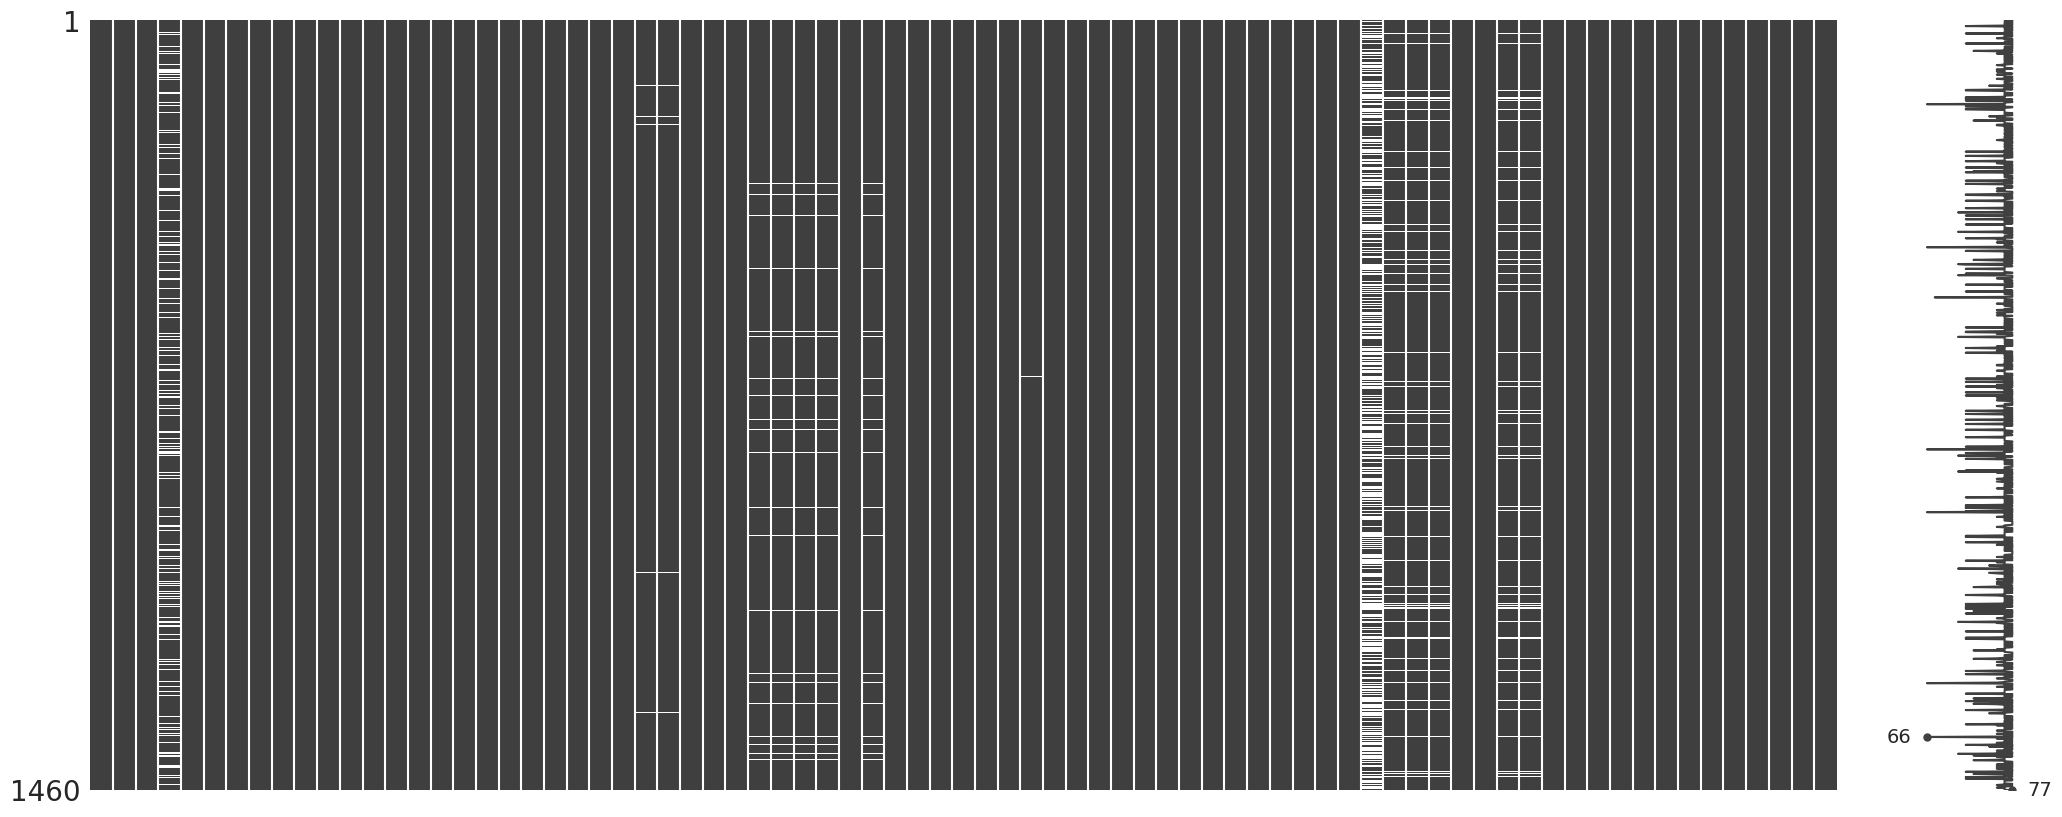

In [ ]:
msno.matrix(df.sample(df.shape[0]))

In [ ]:
L = df.isnull().sum()
miss = round(L[L>0] / df.shape[0],4)*100

In [ ]:
miss

LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

In [ ]:
# drop columns with more than 80% missing values
df = df.drop(list(miss[miss > 80].index),axis=1)

### Replacing some missing values

In [ ]:
miss = miss[miss <= 80]

In [ ]:
variable_to_update = list(miss.index)
numeric_to_update = ['MasVnrArea','LotFrontage']
categ_to_update = list(set(variable_to_update)-set(numeric_to_update))

In [ ]:
for col in categ_to_update:
  print("no_"+str(col))
  df[col] = df[col].replace(np.nan,"no_"+str(col))

no_BsmtFinType2
no_GarageType
no_GarageQual
no_GarageFinish
no_BsmtFinType1
no_GarageYrBlt
no_GarageCond
no_FireplaceQu
no_Electrical
no_BsmtCond
no_BsmtExposure
no_MasVnrType
no_BsmtQual


In [ ]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

### Some Features Transformations

#### Year variables

In [ ]:
for col in df.columns:
  if 'Y' in col:
    print(col)
    #sn.displot(df[col])

YearBuilt
YearRemodAdd
GarageYrBlt
YrSold


##### YearBuilt

In [ ]:
def f(x):
  if x >= 1995:
    return "after95"
  else:
    if x >= 1960:
      return "betw60&95"
    else:
      return "before60"

df['YearBuilt'] = df['YearBuilt'].apply(lambda x : f(x))

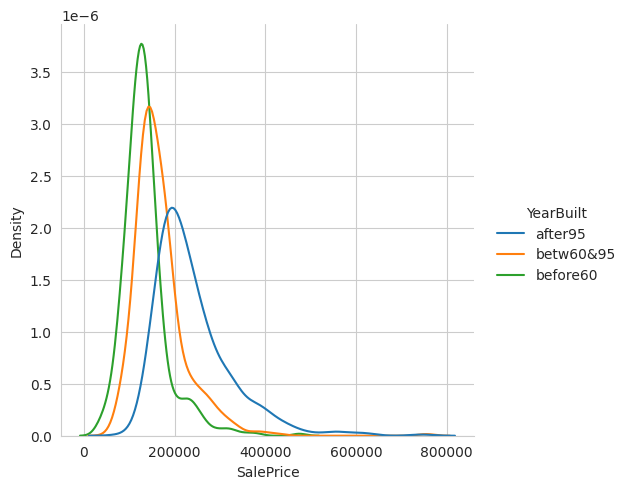

In [ ]:
sn.displot(x = df["SalePrice"], hue = df['YearBuilt'], kind = 'kde', fill = False)

##### YearRemodAdd

In [ ]:
def f2(x):
  if x >= 1990:
    return "after90"
  else:
    return "before90"


df['YearRemodAdd'] = df['YearRemodAdd'].apply(lambda x : f2(x))

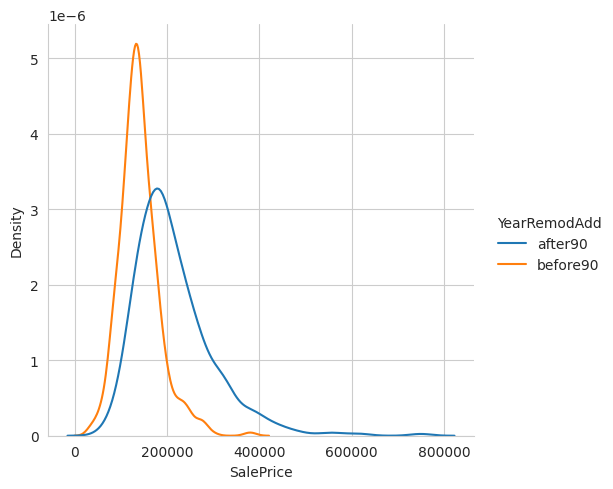

In [ ]:
sn.displot(x = df["SalePrice"], hue = df['YearRemodAdd'], kind = 'kde', fill = False)

##### GarageYrBlt

In [ ]:
def f3(x):
  if x ==-1:
    return "no_GarageYrBlt"
  else:
    if x >= 1980:
      return "after80"
    else:
      return "before80"

In [ ]:
df['GarageYrBlt'] = df['GarageYrBlt'].replace('no_GarageYrBlt',-1).apply(lambda x : f3(x))

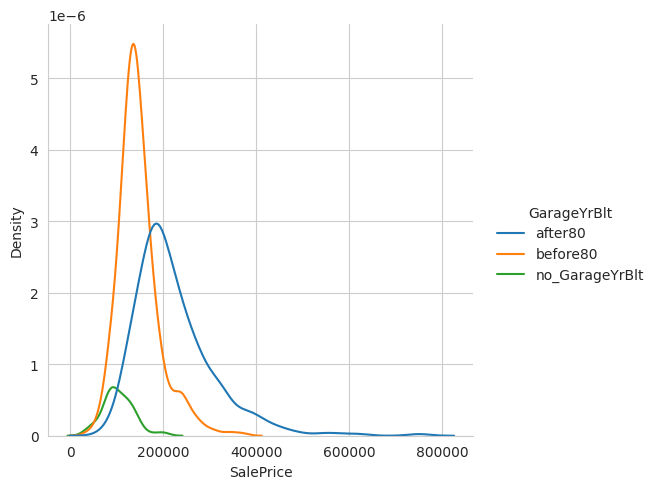

In [ ]:
sn.displot(x = df["SalePrice"], hue = df['GarageYrBlt'], kind = 'kde', fill = False)

##### YrSold

In [ ]:
df['YrSold'] = df['YrSold'].astype('category')

### Categorical / numerical separation

In [ ]:
df['MSSubClass'] = df['MSSubClass'].astype('category')

In [ ]:
df.drop(['Id'],axis=1,inplace=True)

In [ ]:
categ = df[df.columns[:-1]].select_dtypes(include = ['object','category']).columns

In [ ]:
numeric = df[df.columns[:-1]].select_dtypes(exclude = ['object','category']).columns

#### Dropping the constant variables

In [ ]:
col_to_drop = []
for col in categ:
  dec = round(df[col].value_counts() / df.shape[0],4)*100
  if dec.iloc[0,]>=94:
    col_to_drop.append(col)

In [ ]:
df.drop(col_to_drop,axis=1,inplace=True)

In [ ]:
categ = list(set(categ)-set(col_to_drop))

In [ ]:
col_to_drop = []
for col in numeric:
  dec = round(df[col].value_counts() / df.shape[0],4)*100
  if dec.iloc[0,]>=94:
    col_to_drop.append(col)

In [ ]:
df.drop(col_to_drop,axis=1,inplace=True)

In [ ]:
numeric = list(set(numeric)-set(col_to_drop))

#### Numeric to categoric

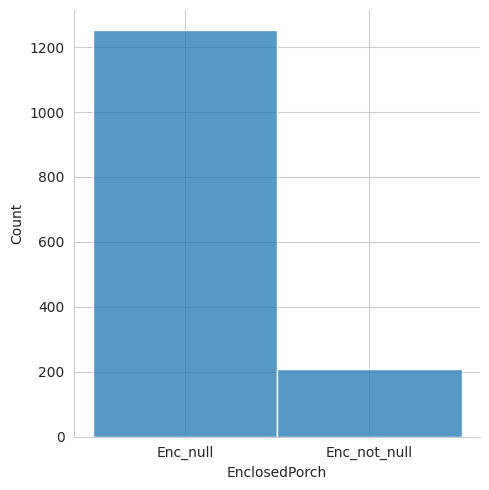

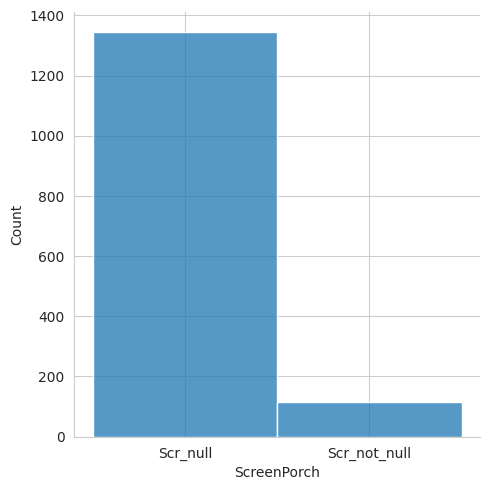

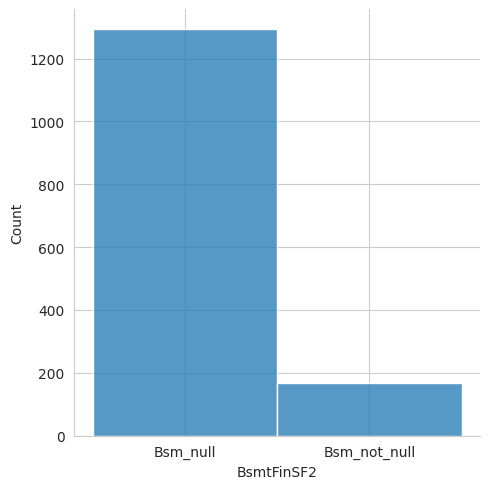

In [ ]:
for col in numeric:
  dec = round(df[col].value_counts() / df.shape[0],4)*100
  if dec.iloc[0,]>=75:
    df[col] = df[col].apply(lambda x : col[:3]+"_not_null" if x>0 else col[:3]+"_null")
    sn.displot(df[col])

In [ ]:
categ+=["ScreenPorch","EnclosedPorch","BsmtFinSF2"]

In [ ]:
numeric = list(set(numeric)-set(["ScreenPorch","EnclosedPorch","BsmtFinSF2"]))

### Correlation

<Axes: >

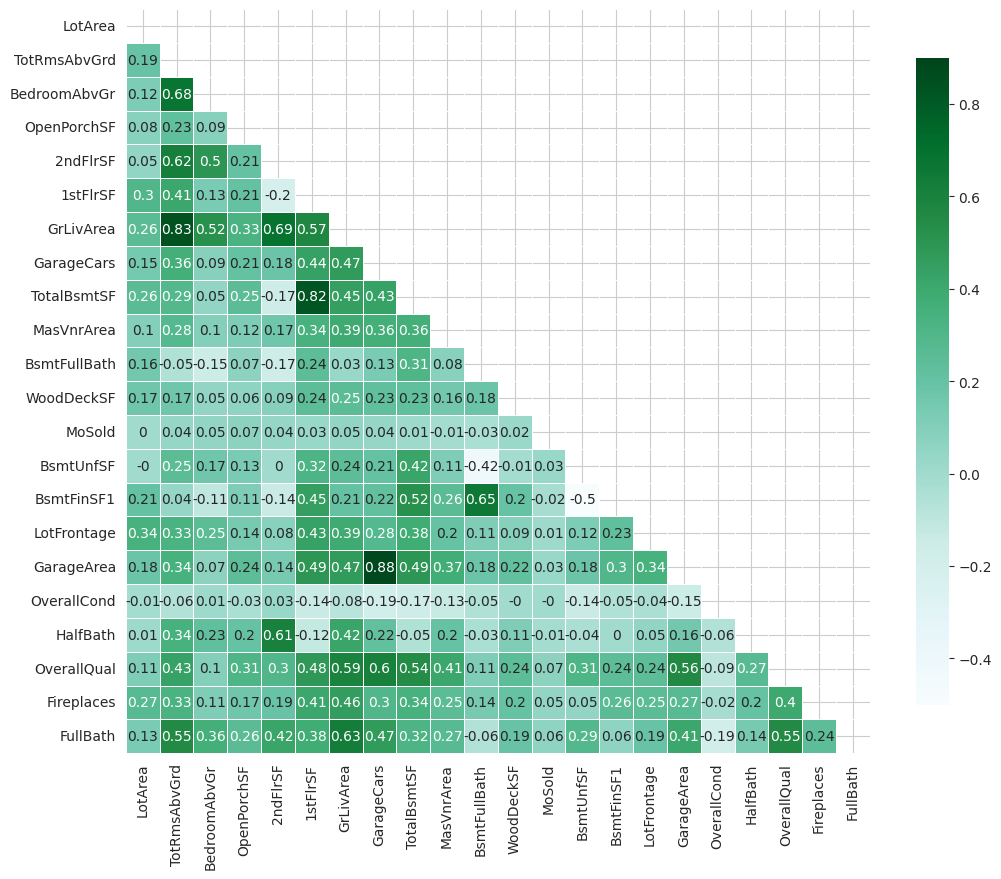

In [ ]:
# Matrice des corrélations de Pearson
corr = round(df[numeric].corr(method = 'pearson'),2)
fig, ax = plt.subplots(figsize = (12,12))
mask = np.triu(np.ones_like(corr, dtype=bool)) #mask upper triangle
sn.heatmap(corr, mask=mask, vmax = 0.9, cmap='BuGn', square = True, annot = True, linewidths=.5, cbar_kws={"shrink": .7})

In [ ]:
# High correlated unique pairs
foo = df[numeric].corr()
pairs = foo.where(np.triu(foo, k=1).astype(bool)).stack()
pairs[pairs.abs().gt(0.8)]

TotRmsAbvGrd  GrLivArea      0.825489
1stFlrSF      TotalBsmtSF    0.819530
GarageCars    GarageArea     0.882475
dtype: float64

In [ ]:
df.drop(['GarageCars'],axis=1,inplace=True)

In [ ]:
numeric.remove('GarageCars')

### Target variable analysis

<ipython-input-41-3ed12865ad70>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)


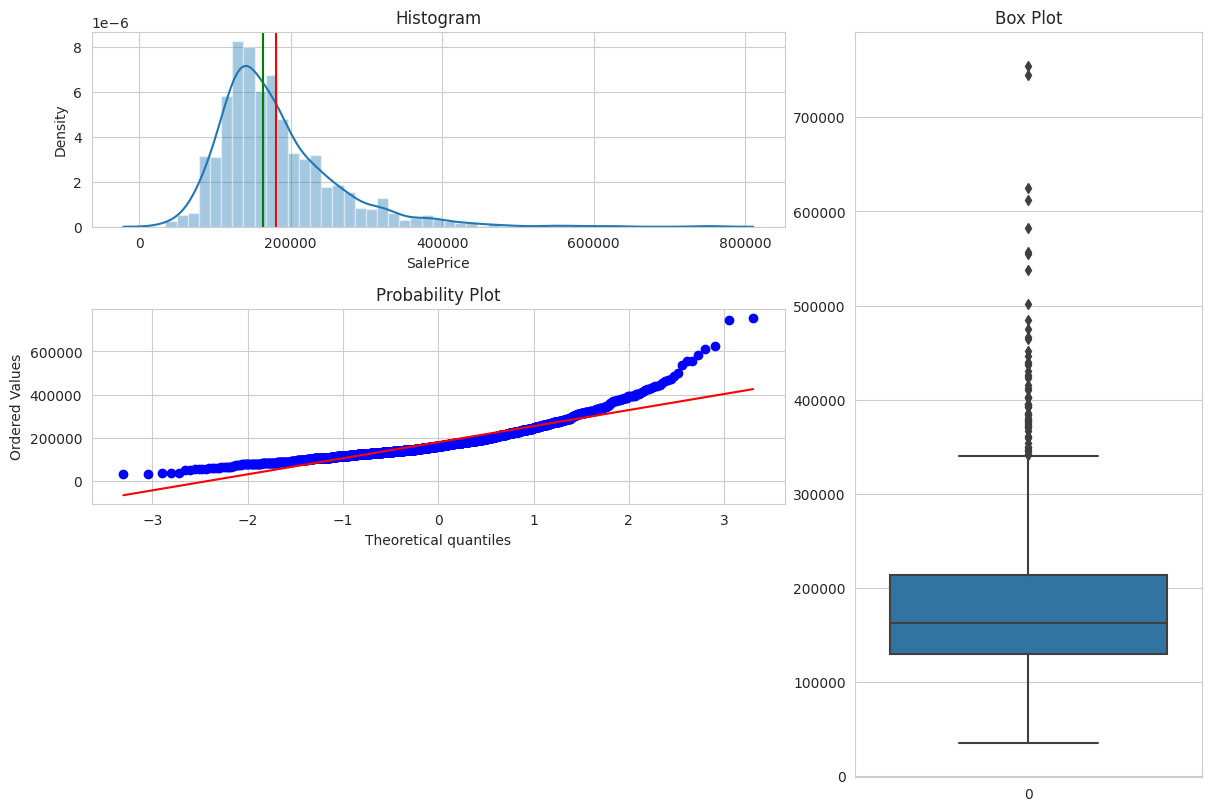

In [ ]:
def three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)

    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')

    sn.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')

    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title.
    ax3.set_title('Box Plot')
    sn.boxplot(df.loc[:,feature], orient = 'v', ax = ax3 )

three_chart_plot(df, 'SalePrice')

#### Outliers Analysis and Distribution Improvement

In [ ]:
np.percentile(df['SalePrice'],98)

394931.06

In [ ]:
df = df[(df['SalePrice'] < np.percentile(df['SalePrice'],98))].reset_index(drop=True)

In [ ]:
df['logSalePrice'] = np.log(df['SalePrice'])

In [ ]:
np.percentile(df['logSalePrice'],1)

11.025130635229747

In [ ]:
df2 = df[(df['logSalePrice'] >= np.percentile(df['logSalePrice'],2))].reset_index(drop=True)

<ipython-input-41-3ed12865ad70>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)


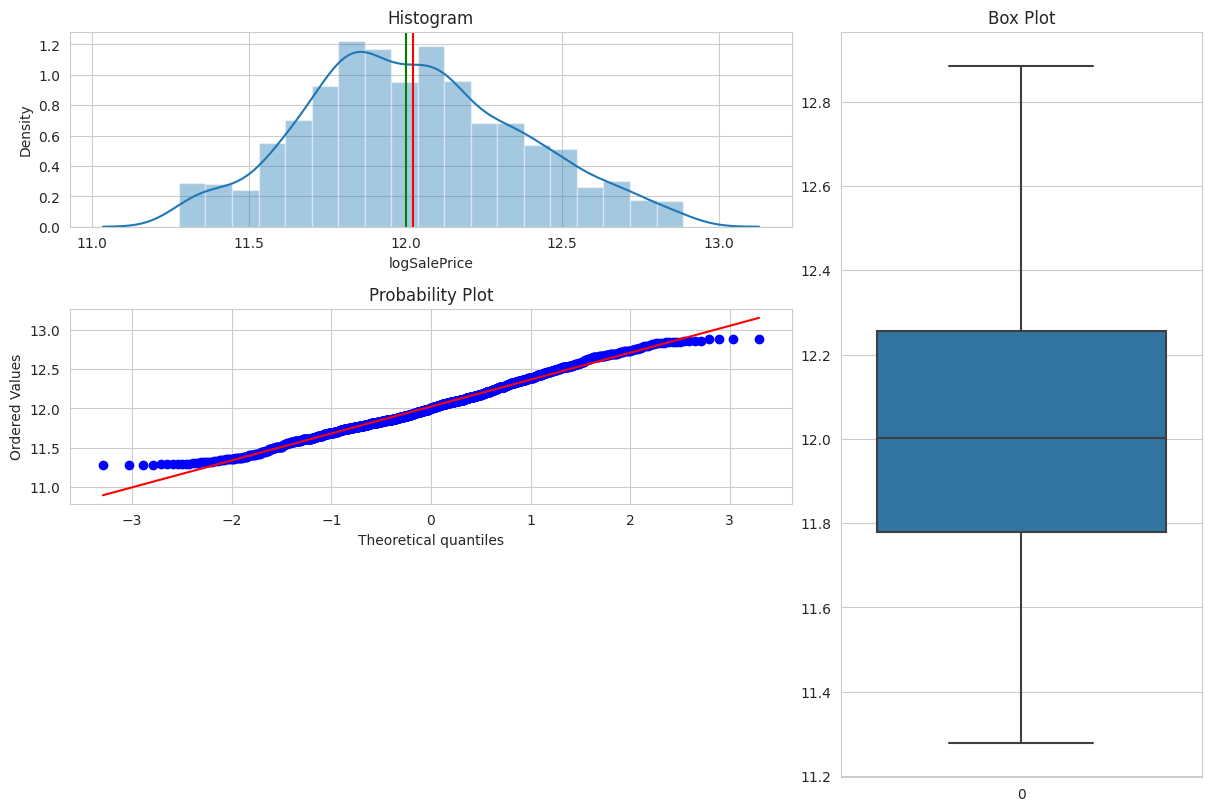

In [ ]:
three_chart_plot(df2, 'logSalePrice')

### Categorical Encoding

In [ ]:
df3 = df2.copy()
# Transform all categorical variables into numerical (by encoding)
categ_dumm = []
for col in categ:
    if len(df3[col].value_counts())==2:
        df3[col] = df3[col].replace({df3[col].value_counts().index[0]:0,df3[col].value_counts().index[1]:1})
    else:
        dumm = pd.get_dummies(df3[col])
        for colu in dumm.columns:
          if colu in categ_dumm:
            dumm = dumm.rename(columns={colu:colu+"_"+col})
        categ_dumm+=list(dumm.columns)
        df3 = df3.merge(dumm, left_index = True, right_index = True).reset_index(drop = True)
        df3.drop([col],axis=1,inplace=True)

In [ ]:
df3

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Stone_MasVnrType,no_MasVnrType,Ex_KitchenQual,Fa_KitchenQual,Gd_KitchenQual,TA_KitchenQual,Bnk,HLS,Low,Lvl
0,65.0,8450,7,5,0,196.0,706,0,150,856,...,0,0,0,0,1,0,0,0,0,1
1,80.0,9600,6,8,1,0.0,978,0,284,1262,...,0,0,0,0,0,1,0,0,0,1
2,68.0,11250,7,5,0,162.0,486,0,434,920,...,0,0,0,0,1,0,0,0,0,1
3,60.0,9550,7,5,1,0.0,216,0,540,756,...,0,0,0,0,1,0,0,0,0,1
4,84.0,14260,8,5,0,350.0,655,0,490,1145,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,62.0,7917,6,5,0,0.0,0,0,953,953,...,0,0,0,0,0,1,0,0,0,1
1397,85.0,13175,6,6,1,119.0,790,1,589,1542,...,1,0,0,0,0,1,0,0,0,1
1398,66.0,9042,7,9,0,0.0,275,0,877,1152,...,0,0,0,0,1,0,0,0,0,1
1399,68.0,9717,5,6,0,0.0,49,1,0,1078,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
df3 = df3.T.drop_duplicates().T

In [ ]:
for col in df3.columns:
  if type(col)==int:
    df3.rename(columns={col:str(col)},inplace=True)

### Data Separation

In [ ]:
X = df3.drop(['SalePrice','logSalePrice'],axis=1)
y = df3['logSalePrice']

#### Data Normalization

In [ ]:
categories = list(set(X.columns)-set(numeric))
X_num = X[numeric]
X_cat = X[categories]
scale = StandardScaler()
scale.fit(X_num)
X_num_scal = scale.transform(X_num)
X_norm = pd.concat([pd.DataFrame(X_num_scal,columns=numeric),X_cat],axis=1)

#### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [ ]:
X_train_scal, X_test_scal, y_train_scal, y_test_scal = train_test_split(X_norm, y, test_size = 0.25, random_state = 25)

In [ ]:
X_train.shape, X_test.shape

((1050, 260), (351, 260))

### Error Analysis Functions

In [ ]:
def mape (y_pred, y_test = y_test):
  mape = np.abs((y_test - y_pred) / y_test) * 100

  df_y_pred = pd.DataFrame(data = y_pred, columns = ['y_pred'])
  df_y_test = pd.DataFrame(data = list(y_test), columns = ['y_test'])
  df_mape = pd.DataFrame(data = list(mape), columns = ['mape'])
  df_error = pd.concat([df_y_pred, df_y_test, df_mape], axis = 1)
  df_error.head()
  return mape, df_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def DataFrame_score (y_train_pred, y_pred, y_train = y_train, y_test = y_test):
  DF = pd.DataFrame(
    {'train': [mean_squared_error(y_train, y_train_pred),
               mean_absolute_error(y_train, y_train_pred),
               r2_score(y_train, y_train_pred),
               mean_absolute_percentage_error(y_train, y_train_pred),
               median_absolute_percentage_error(y_train, y_train_pred)],

     'test': [mean_squared_error(y_test, y_pred),
               mean_absolute_error(y_test, y_pred),
               r2_score(y_test, y_pred),
               mean_absolute_percentage_error(y_test, y_pred),
               median_absolute_percentage_error(y_test, y_pred)]},\

               index = ['MSE', 'MAE', 'R2', 'Mean_abs_perc_error', 'Median_abs_perc_error']
  )
  return DF

### Models

#### Linear Regression

In [ ]:
LR = LinearRegression()
LR.fit(X_train, y_train)
y_train_LR_pred = LR.predict(X_train)
y_LR_pred = LR.predict(X_test)

mape_LR, df_error_LR = mape(y_LR_pred, y_test)

DataFrame_score(y_train_LR_pred, y_LR_pred,y_train,y_test)

,train,test
MSE,0.010703,0.012234
MAE,0.072585,0.081382
R2,0.913434,0.879893
Mean_abs_perc_error,0.603769,0.681082
Median_abs_perc_error,0.468113,0.537439


In [ ]:
error.loc[error['Abs_error'].idxmax(),:]

y_test       11.979385
y_pred       11.509002
Abs_error     0.470383
Name: 650, dtype: float64

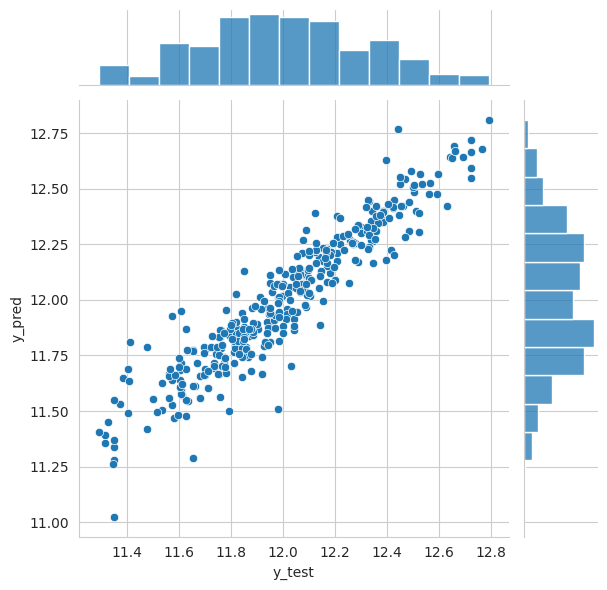

In [ ]:
sn.jointplot(data = df_error_LR, x = "y_test", y = "y_pred")

#### Random Forest

In [ ]:
RFR_reg = RandomForestRegressor(max_depth = 50,max_features=20, n_estimators = 200, random_state = 2)
RFR_reg.fit(X_train, y_train)
y_train_RFR2_pred = RFR_reg.predict(X_train)
y_RFR2_pred = RFR_reg.predict(X_test)

mape_RFR2, df_error_RFR2_reg = mape(y_RFR2_pred, y_test)

DataFrame_score(y_train_RFR2_pred, y_RFR2_pred,y_train,y_test)

,train,test
MSE,0.002306,0.012153
MAE,0.033887,0.081707
R2,0.981349,0.880691
Mean_abs_perc_error,0.282008,0.684295
Median_abs_perc_error,0.196163,0.480694


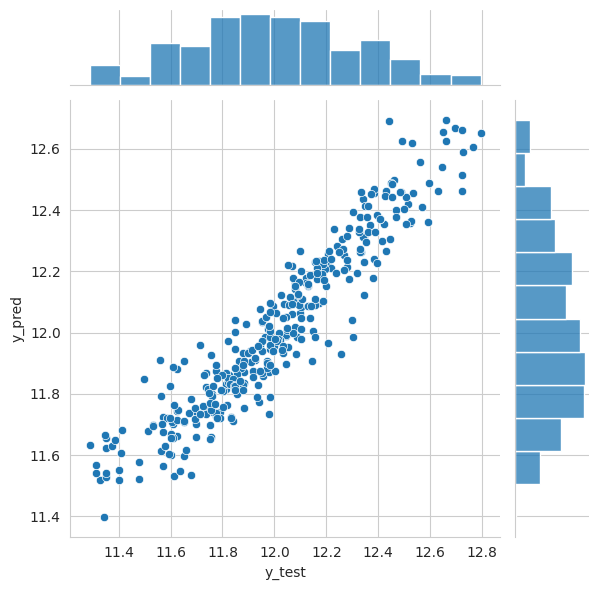

In [ ]:
sn.jointplot(data = df_error_RFR2_reg, x = "y_test", y = "y_pred")

#### Gradient Boosting

In [ ]:
GBR = GradientBoostingRegressor(learning_rate = 0.1, \
                                  n_estimators = 200, random_state = 2)
GBR.fit(X_train, y_train)
y_train_GBR_pred = GBR.predict(X_train)
y_GBR_pred = GBR.predict(X_test)

mape_GBR, df_error_GBR = mape(y_GBR_pred, y_test)

DataFrame_score(y_train_GBR_pred, y_GBR_pred,y_train,y_test)

,train,test
MSE,0.003217,0.011023
MAE,0.043636,0.079754
R2,0.973981,0.891785
Mean_abs_perc_error,0.363334,0.667377
Median_abs_perc_error,0.299164,0.514925


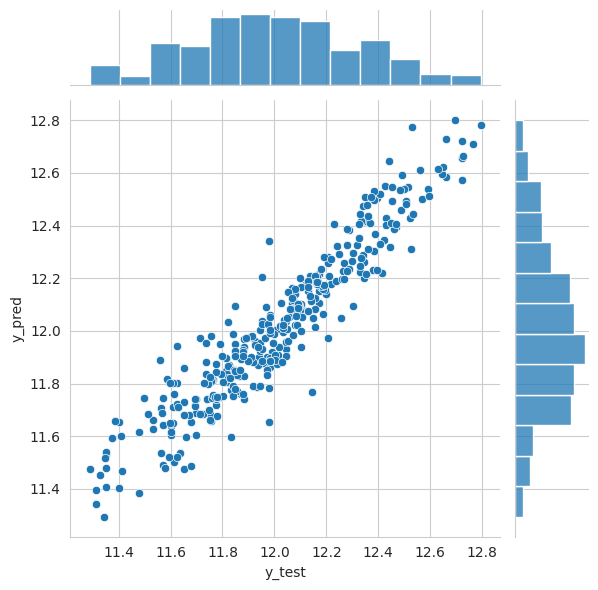

In [ ]:
sn.jointplot(data = df_error_GBR, x = "y_test", y = "y_pred")

#### Epsilon-Support Vector Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_scal, y_train_scal)

grid.best_params_

In [ ]:
model = SVR(kernel = 'rbf', C = 10, gamma = 0.001, epsilon = 0.1)
model.fit(X_train_scal, y_train_scal)
y_SVR_pred = model.predict(X_test_scal)
y_train_SVR_pred = model.predict(X_train_scal)

mape_SVR, df_error_SVR = mape(y_SVR_pred, y_test_scal)

DataFrame_score(y_train_SVR_pred, y_SVR_pred,y_train_scal,y_test_scal)

,train,test
MSE,0.007852,0.008557
MAE,0.065292,0.071168
R2,0.936495,0.915992
Mean_abs_perc_error,0.544582,0.595395
Median_abs_perc_error,0.462572,0.492021


In [ ]:
error = pd.DataFrame({'y_test':np.exp(y_test),'y_pred':np.round(np.exp(y_SVR_pred)) })
error.head(60)

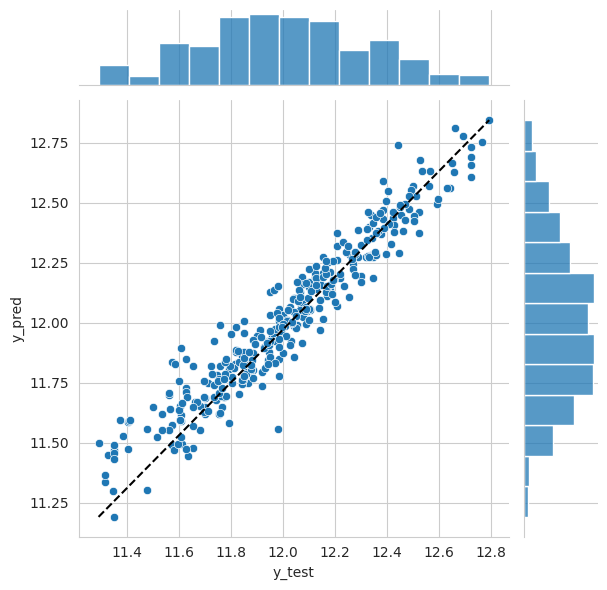

In [ ]:
graph = sn.jointplot(data=df_error_SVR, x="y_test", y="y_pred")

# Tracer la fonction identité (y=x)
identity_line = sn.lineplot(x=[df_error_SVR["y_test"].min(), df_error_SVR["y_test"].max()],
                             y=[df_error_SVR["y_pred"].min(), df_error_SVR["y_pred"].max()],
                             color="black", linestyle="--", ax=graph.ax_joint)



# Afficher le graphique
plt.show()

### Feature importances

In [ ]:
perm_importance = permutation_importance(model, X_test_scal, y_test_scal)

Text(0.5, 0, 'Permutation Importance')

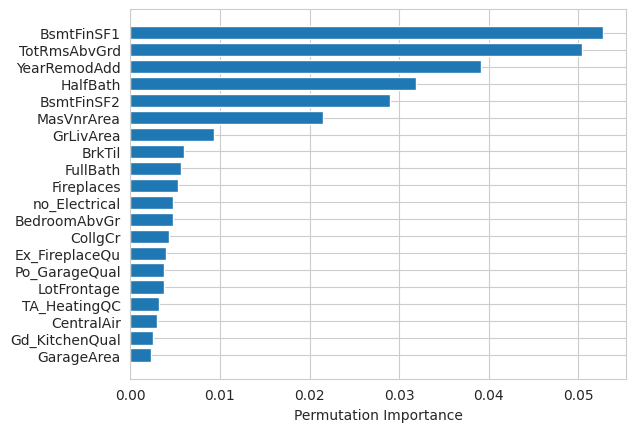

In [ ]:
feature_names = list(X.columns)
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx][::-1][:20][::-1], perm_importance.importances_mean[sorted_idx][::-1][:20][::-1])
plt.xlabel("Permutation Importance")